# Import

In [1]:
import pickle

# math and dataframes
import pandas as pd
import numpy as np

# statistics
from sklearn.metrics import r2_score
from scipy.stats import friedmanchisquare, wilcoxon
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Pipeline and Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

In [2]:
df_predictions = pd.read_pickle('df_predictions.pickle')

In [3]:
# columns for datasets

y_column = 'in_B100'
X_columns = [
    'mode', 'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
genre_columns = [
    'is_Adult_Standard', 'is_Rock', 'is_R&B', 'is_Country', 'is_Pop',
    'is_Rap', 'is_Alternative', 'is_EDM', 'is_Metal'
]
cluster_columns = ['cluster', 'cluster2']
other_columns = ['key', 'time_signature', 'genre', 'release_date']
prediction_columns = [
    'y_lr', 'y_dt', 'y_knn', 'y_rf', 'y_ab', 'y_lr_tuned', 'y_dt_tuned', 
    'y_cl_1', 'y_cl_2', 'y_genres'
]

# Explore Predictions

In [4]:
df_predictions[prediction_columns].describe().T.iloc[:-1]

,count,unique,top,freq
y_lr,8827719,2,False,5012328
y_dt,8827719,2,False,5759549
y_knn,8827719,2,False,5389246
y_rf,8827719,2,False,5972306
y_ab,8827719,2,False,5368640
y_lr_tuned,8827719,2,False,5015482
y_dt_tuned,8827719,2,False,5730894
y_cl_1,8827719,2,False,5524314
y_cl_2,8827719,2,False,5445396


In [5]:
# where genre data is available
df_predictions[~df_predictions.y_genres.isna()][prediction_columns].describe().T

,count,unique,top,freq
y_lr,2808901,2,False,1632876
y_dt,2808901,2,False,1856456
y_knn,2808901,2,False,1747625
y_rf,2808901,2,False,1934264
y_ab,2808901,2,False,1746821
y_lr_tuned,2808901,2,False,1633972
y_dt_tuned,2808901,2,False,1855688
y_cl_1,2808901,2,False,1792586
y_cl_2,2808901,2,False,1769889
y_genres,2808901,2,False,1693361


# PCA Scatterplots

In [6]:
pca = PCA()
transformer = StandardScaler()

# transform the data
transformed_X = transformer.fit_transform(df_predictions[X_columns])

# get the PCA
pca_data = pca.fit_transform(transformed_X)

In [9]:
df_predictions = pd.concat([
    df_predictions, 
    pd.DataFrame(pca_data).rename({0: 'PCA1', 1: 'PCA2'}, axis=1)[['PCA1', 'PCA2']]
], axis=1)

In [10]:
pd.DataFrame(pca_data).rename({0: 'PCA1', 1: 'PCA2'}, axis=1)[['PCA1', 'PCA2']].describe()

,PCA1,PCA2
count,8827719.000,8827719.000
mean,-0.000,-0.000
std,1.761,1.215
min,-3.878,-5.615
25%,-1.352,-0.834
50%,-0.462,-0.072
75%,1.055,0.781
max,5.945,5.697


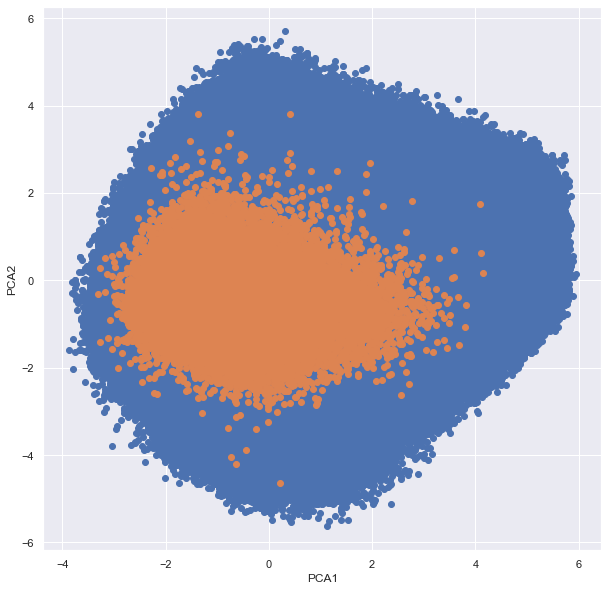

In [12]:
figsize = (10, 10)
plot_x, plot_y = 'PCA1', 'PCA2'
plt.figure(figsize=figsize)
plt.scatter(df_predictions[~df_predictions.in_B100][plot_x], df_predictions[~df_predictions.in_B100][plot_y])
plt.scatter(df_predictions[df_predictions.in_B100][plot_x], df_predictions[df_predictions.in_B100][plot_y])
plt.xlabel(plot_x)
plt.ylabel(plot_y)
plt.show()

In [40]:
def pca_plot(n_scenario, plot_x='PCA1', plot_y='PCA2'):
    
    # evaluated scenarios
    scenarios_dict = {
        0: 'Logistic Regression - Default Hyperparameters',
        1: 'Decision Tree - Default Hyperparameters',
        2: 'K-Nearest Neighbours - Default Hyperparameters',
        3: 'Random Forest - Default Hyperparameters',
        4: 'AdaBoost - Default Hyperparameters',
        5: 'Logistic Regression - Tuned Hyperparameters',
        6: 'Decision Tree - Tuned Hyperparameters',
        7: 'Logistic Regression - Clustered By KMeans Version 1',
        8: 'Logistic Regression - Clustered By KMeans Version 2',
        9: 'Logistic Regression - Clustered By Genre'
    }
    print('Comparison of Predicted and Actual Billboard Hits:', scenarios_dict[n_scenario])

    figsize = (16, 12)
    markersize = 20
    alpha = 1

    # setup the plot
    plt.figure(figsize=figsize)
    
    # labels
    if plot_x[:3] == 'PCA':
        xlabel = 'Principal Component '+ plot_x[-1]
    else:
        xlabel = plot_x.title().replace('_', ' ')
    
    if plot_y[:3] == 'PCA':
        ylabel = 'Principal Component '+ plot_y[-1]
    else:
        ylabel = plot_y.title().replace('_', ' ')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    # actually no
    plt.scatter(
        df_predictions[~df_predictions.in_B100][plot_x], 
        df_predictions[~df_predictions.in_B100][plot_y], 
        label='Not in Billboard Hot 100', 
        s=markersize,
        alpha=alpha
    )

    # predicted yes
    plt.scatter(
        df_predictions[df_predictions[prediction_columns[n_scenario]]][plot_x], 
        df_predictions[df_predictions[prediction_columns[n_scenario]]][plot_y], 
        color=sns.color_palette()[2], 
        label='Predicted to be Popular', 
        s=markersize,
        alpha=alpha
    )

    # actually yes
    plt.scatter(
        df_predictions[df_predictions.in_B100][plot_x], 
        df_predictions[df_predictions.in_B100][plot_y], 
        color=sns.color_palette()[1],
        label='In Billboard Hot 100', 
        s=markersize,
        alpha=alpha
    )
    
    # legend
    plt.legend(loc='upper right')

    plt.show()
    

In [ ]:
%%time
for i in range(10):
    pca_plot(i)

Comparison of Predicted and Actual Billboard Hits: Logistic Regression - Default Hyperparameters


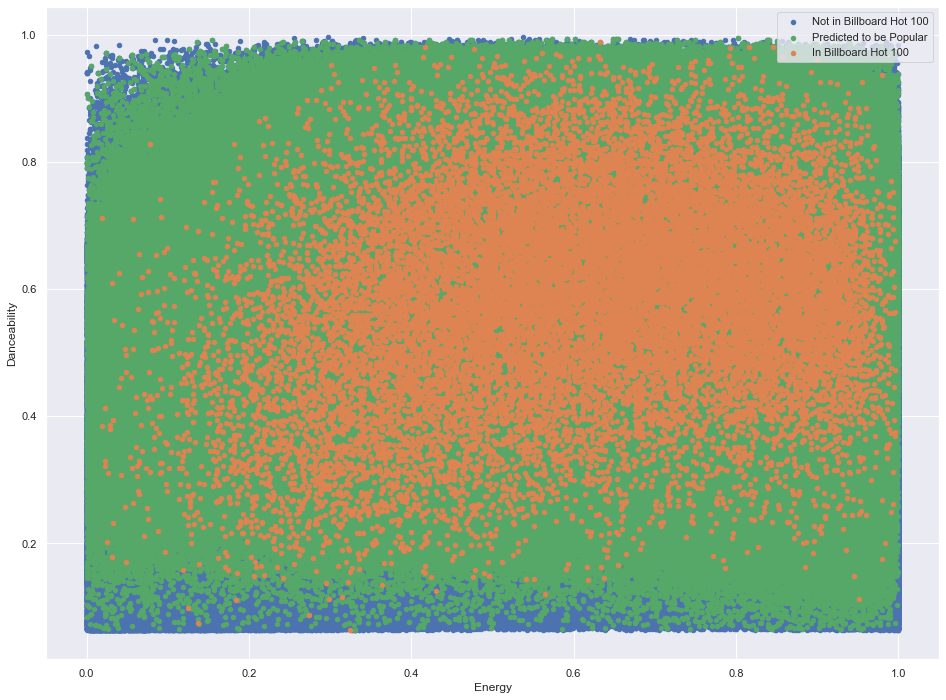

In [33]:
# check how this plot looks with audio features
pca_plot(0, 'energy', 'danceability')

# Histograms

Histogram: Principal Component 1


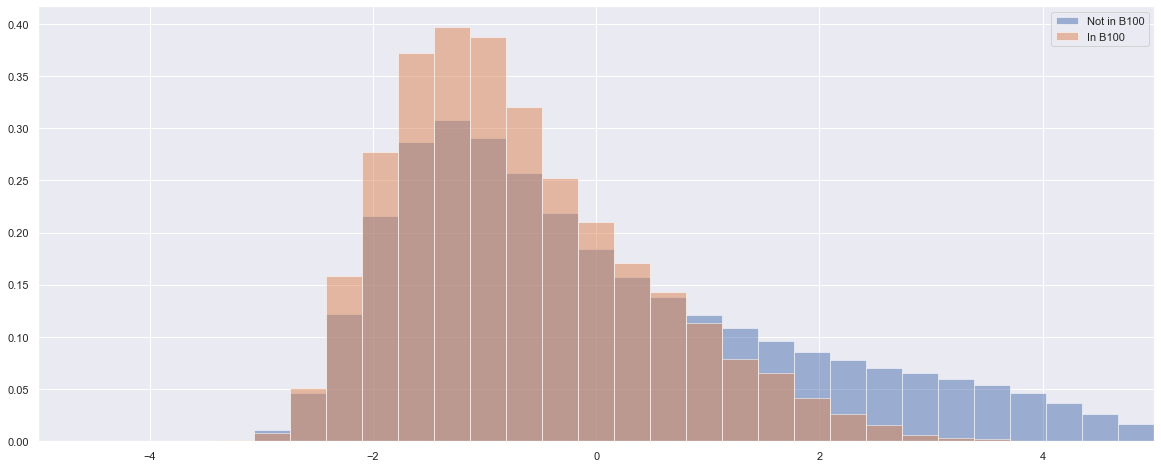

Histogram: Principal Component 2


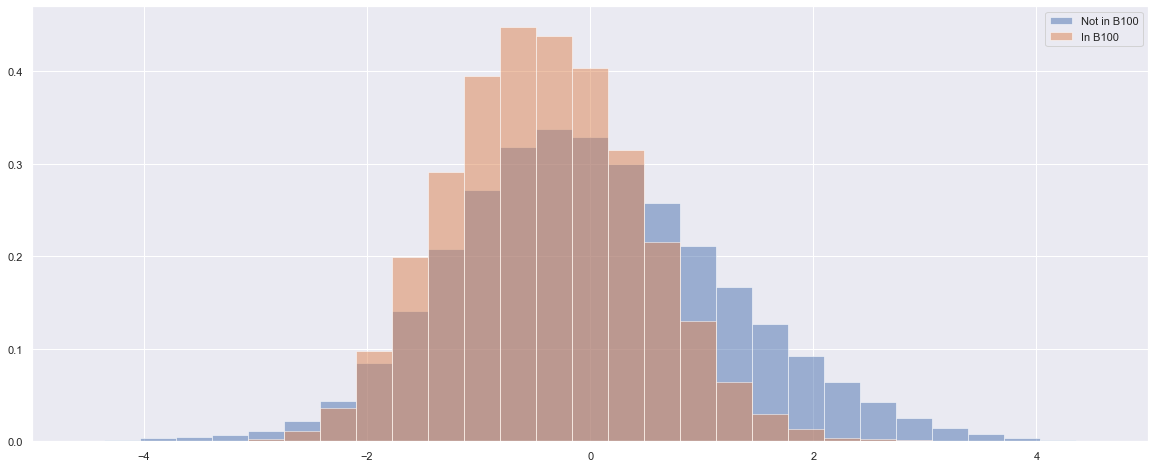

In [39]:
# check histograms for PCA

bins = 30
xmin, xmax = -5, 5
bins_plot = [(x/(bins+1))*(xmax-xmin)+xmin for x in range(bins+2)]         
figsize = (20, 8)

print('Histogram: Principal Component 1')

plt.figure(figsize=figsize)
plt.xlim(xmin, xmax)

plt.hist(df_predictions[~df_predictions.in_B100]['PCA1'], bins_plot, alpha=0.5, density=True, label='Not in B100')
plt.hist(df_predictions[df_predictions.in_B100]['PCA1'], bins_plot, alpha=0.5, density=True, label='In B100')

plt.legend(loc='upper right')
plt.show()

print('Histogram: Principal Component 2')

plt.figure(figsize=figsize)
plt.xlim(xmin, xmax)

plt.hist(df_predictions[~df_predictions.in_B100]['PCA2'], bins_plot, alpha=0.5, density=True, label='Not in B100')
plt.hist(df_predictions[df_predictions.in_B100]['PCA2'], bins_plot, alpha=0.5, density=True, label='In B100')

plt.legend(loc='upper right')
plt.show()

# Statistics
* Friedman Test (Wilcoxn if required)
* R Squared